In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')

### Dataset: VHM Historical Data

In [27]:
data = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,68421.0,66541.0,68722.0,65789.0,1.05M,4.00%
2019-03-04,70075.0,69173.0,70300.0,67368.0,1.18M,2.42%
2019-03-05,68421.0,69323.0,69849.0,68045.0,1.50M,-2.36%
2019-03-06,69022.0,68421.0,69097.0,68270.0,770.13K,0.88%
2019-03-07,69173.0,69173.0,71654.0,69097.0,1.70M,0.22%
...,...,...,...,...,...,...
2024-05-27,39800.0,39850.0,40050.0,39750.0,4.62M,0.00%
2024-05-28,39950.0,39850.0,40050.0,39750.0,5.56M,0.38%
2024-05-29,39450.0,40000.0,40100.0,39450.0,8.03M,-1.25%


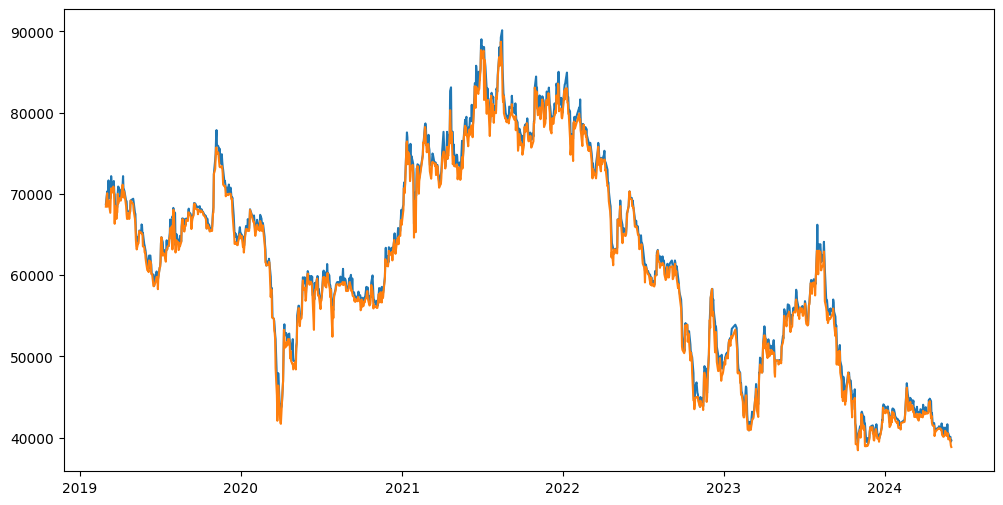

In [28]:
y = data[['Price']] # dependent variable
X = data[['High']] # independent variable
plt.figure(figsize=(12, 6))
plt.plot(X)
plt.plot(y)
plt.show()

#### Ratio 7:3

In [29]:
# Split data into train and test
train_size = int(0.7 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [30]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [31]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [32]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([44634.0684371]), array([48076.76504789]), array([50352.33903798]), array([51949.23350812]), array([53113.95006742]), array([53986.3839628]), array([54652.5539756]), array([55168.53331761]), array([55572.5318405]), array([55891.50210347]), array([56144.98384177]), array([56347.45719666]), array([56509.84482709]), array([56640.50533177]), array([56745.91051252]), array([56831.11936364]), array([56900.11743333]), array([56956.06464208]), array([57001.47937456]), array([57038.37726797]), array([57068.37717784]), array([57092.78297663]), array([57112.64727072]), array([57128.82142614]), array([57141.99510642]), array([57152.72768688]), array([57161.47333654]), array([57168.60111142]), array([57174.41111202]), array([57179.14750292])]
Sigmoid: [array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]), array([66090.]),

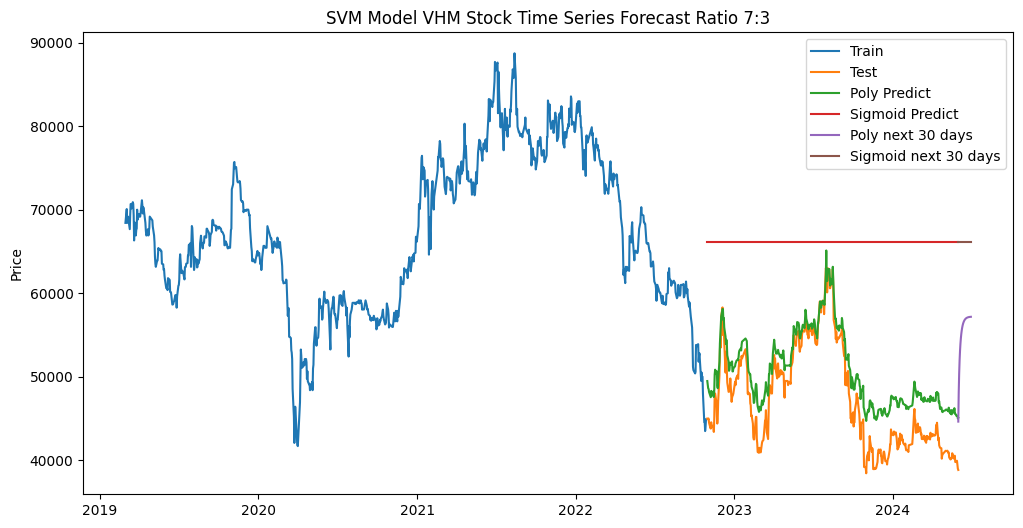

In [33]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model VHM Stock Time Series Forecast Ratio 7:3')
plt.ylabel('Price')
plt.legend()
plt.show()

In [34]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 7.519849475566893
Poly MAE: 3295.4505325041287
Poly RMSE: 3735.483738804099
Sigmoid MAPE: 41.86833417483378
Sigmoid MAE: 18749.39086294416
Sigmoid RMSE: 19738.414349061284


#### Ratio 8:2

In [35]:
# Split data into train and test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [36]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [37]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [38]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([43724.71995444]), array([46696.71586011]), array([48680.85000948]), array([50078.08255359]), array([51096.90031109]), array([51857.96412248]), array([52436.48544276]), array([52881.96932039]), array([53228.37730666]), array([53499.76931517]), array([53713.62827454]), array([53882.91696065]), array([54017.40314981]), array([54124.54319996]), array([54210.08875616]), array([54278.51397465]), array([54333.32295653]), array([54377.27512644]), array([54412.55310008]), array([54440.88941341]), array([54463.66328885]), array([54481.9752308]), array([54496.70499083]), array([54508.55690934]), array([54518.09557338]), array([54525.77398981]), array([54531.95592295]), array([54536.93366283]), array([54540.94218716]), array([54544.17047747])]
Sigmoid: [array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.]), array([64804.

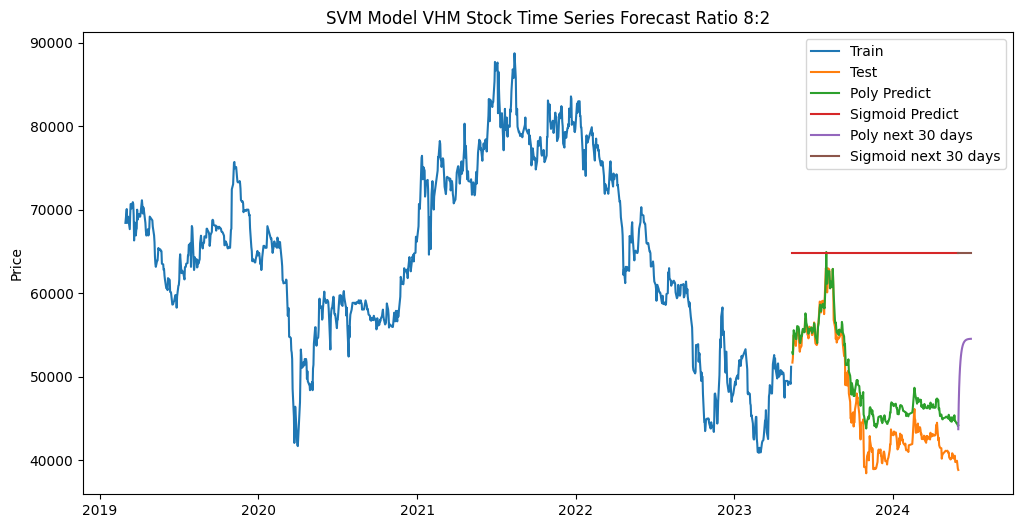

In [39]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model VHM Stock Time Series Forecast Ratio 8:2')
plt.ylabel('Price')
plt.legend()
plt.show()

In [40]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 6.582921149896626
Poly MAE: 2808.12262961261
Poly RMSE: 3282.12179601899
Sigmoid MAPE: 40.69783540552162
Sigmoid MAE: 17781.756653992394
Sigmoid RMSE: 19125.09212264401


#### Ratio 9:1

In [41]:
# Split data into train and test
train_size = int(0.9 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [42]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [43]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [44]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([43160.40080892]), array([45824.69718237]), array([47611.57871498]), array([48869.94543627]), array([49785.00070023]), array([50465.39729464]), array([50979.4932424]), array([51372.56360733]), array([51675.78708219]), array([51911.29190681]), array([52095.15786934]), array([52239.28892094]), array([52352.62840079]), array([52441.97443608]), array([52512.54281543]), array([52568.3650509]), array([52612.5757093]), array([52647.62344631]), array([52675.42826754]), array([52697.50015584]), array([52715.02945213]), array([52728.95629449]), array([52740.02432654]), array([52748.82247169]), array([52755.81756616]), array([52761.37995173]), array([52765.80359717]), array([52769.32195936]), array([52772.1205125]), array([52774.34665257])]
Sigmoid: [array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]), array([63000.]),

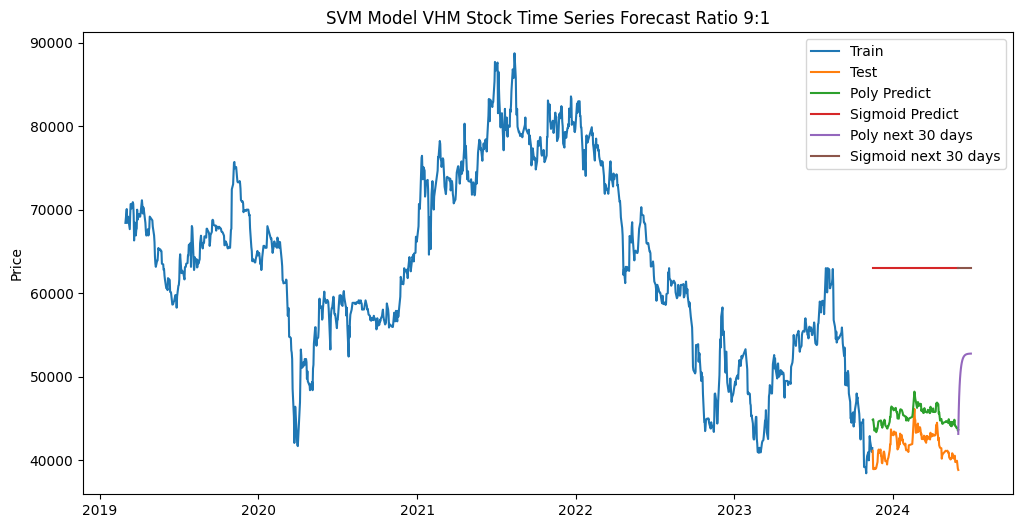

In [45]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model VHM Stock Time Series Forecast Ratio 9:1')
plt.ylabel('Price')
plt.legend()
plt.show()

In [46]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 8.411480528277139
Poly MAE: 3488.2652938446863
Poly RMSE: 3547.9094154540658
Sigmoid MAPE: 50.97603460210194
Sigmoid MAE: 21214.015151515232
Sigmoid RMSE: 21270.711386288694


### Dataset: NVL Historical Data

In [47]:
data = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,32933.0,31765.0,32933.0,31765.0,891.22K,2.95%
2019-03-04,33100.0,32933.0,33378.0,32600.0,899.13K,0.51%
2019-03-05,32711.0,32989.0,33211.0,32544.0,963.79K,-1.18%
2019-03-06,31709.0,32711.0,32711.0,31487.0,1.58M,-3.06%
2019-03-07,31932.0,31709.0,32210.0,31709.0,849.59K,0.70%
...,...,...,...,...,...,...
2024-05-27,14500.0,14600.0,14600.0,14300.0,7.87M,0.35%
2024-05-28,14500.0,14500.0,14600.0,14350.0,11.43M,0.00%
2024-05-29,14150.0,14550.0,14550.0,14150.0,15.86M,-2.41%


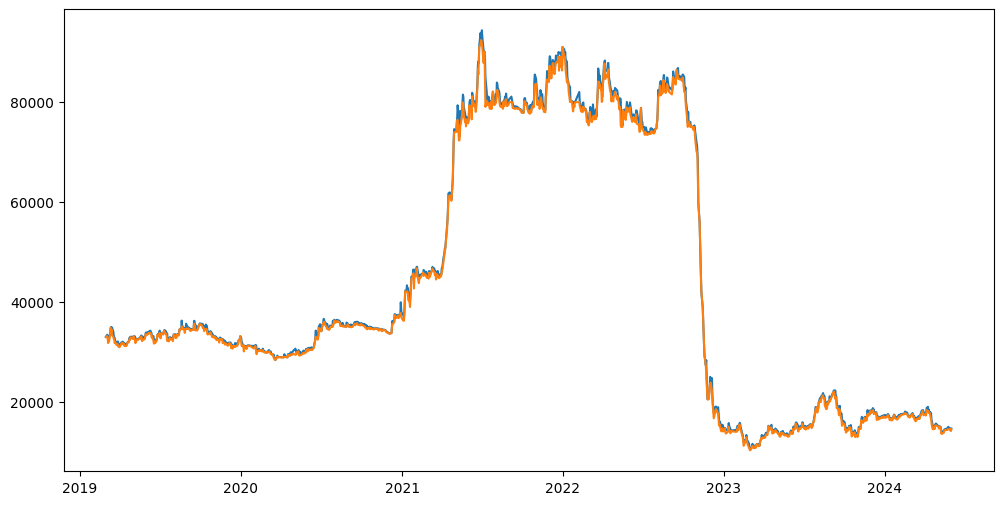

In [48]:
y = data[['Price']] # dependent variable
X = data[['High']] # independent variable
plt.figure(figsize=(12, 6))
plt.plot(X)
plt.plot(y)
plt.show()

#### Ratio 7:3

In [49]:
# Split data into train and test
train_size = int(0.7 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [50]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [51]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [52]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([25490.14673467]), array([29305.4139842]), array([31114.29834005]), array([32059.94723361]), array([32576.85189174]), array([32865.94034824]), array([33029.63445115]), array([33122.96627392]), array([33176.3879037]), array([33207.03341658]), array([33224.63561809]), array([33234.75333713]), array([33240.57141355]), array([33243.91783282]), array([33245.842879]), array([33246.95036026]), array([33247.58752455]), array([33247.95411222]), array([33248.16502886]), array([33248.28638105]), array([33248.35620213]), array([33248.39637443]), array([33248.41948803]), array([33248.43278673]), array([33248.4404383]), array([33248.44484072]), array([33248.44737372]), array([33248.44883111]), array([33248.44966963]), array([33248.45015209])]
Sigmoid: [array([36888.63456716]), array([36883.48727927]), array([36883.49313662]), array([36883.49312995]), array([36883.49312996]), array([36883.49312996]), array([36883.49312996]), array([36883.49312996]), array([36883.49312996]), array([36883.

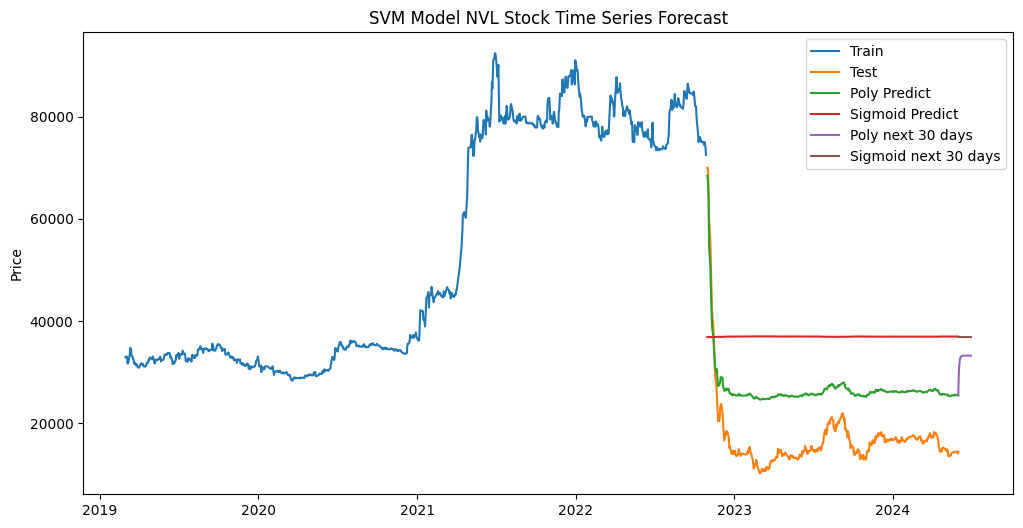

In [53]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model NVL Stock Time Series Forecast')
plt.ylabel('Price')
plt.legend()
plt.show()

In [54]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 66.62431612289991
Poly MAE: 9972.522734816042
Poly RMSE: 10247.847117262021
Sigmoid MAPE: 137.23995181714744
Sigmoid MAE: 21003.52390794696
Sigmoid RMSE: 21321.699754896275


#### Ratio 8:2

In [55]:
# Split data into train and test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [56]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [57]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [58]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([24972.98118629]), array([28604.74407443]), array([30308.20033611]), array([31186.75936353]), array([31659.73600872]), array([31919.96159193]), array([32064.80464758]), array([32145.93876113]), array([32191.54669763]), array([32217.23490132]), array([32231.71955279]), array([32239.89201941]), array([32244.50467376]), array([32247.1086366]), array([32248.57880557]), array([32249.40889935]), array([32249.87760755]), array([32250.14226657]), array([32250.29170963]), array([32250.3760951]), array([32250.4237449]), array([32250.45065128]), array([32250.46584452]), array([32250.47442369]), array([32250.4792681]), array([32250.48200359]), array([32250.48354825]), array([32250.48442047]), array([32250.48491299]), array([32250.4851911])]
Sigmoid: [array([35224.81445091]), array([35214.73097349]), array([35214.76200189]), array([35214.76190638]), array([35214.76190668]), array([35214.76190668]), array([35214.76190668]), array([35214.76190668]), array([35214.76190668]), array([35214.

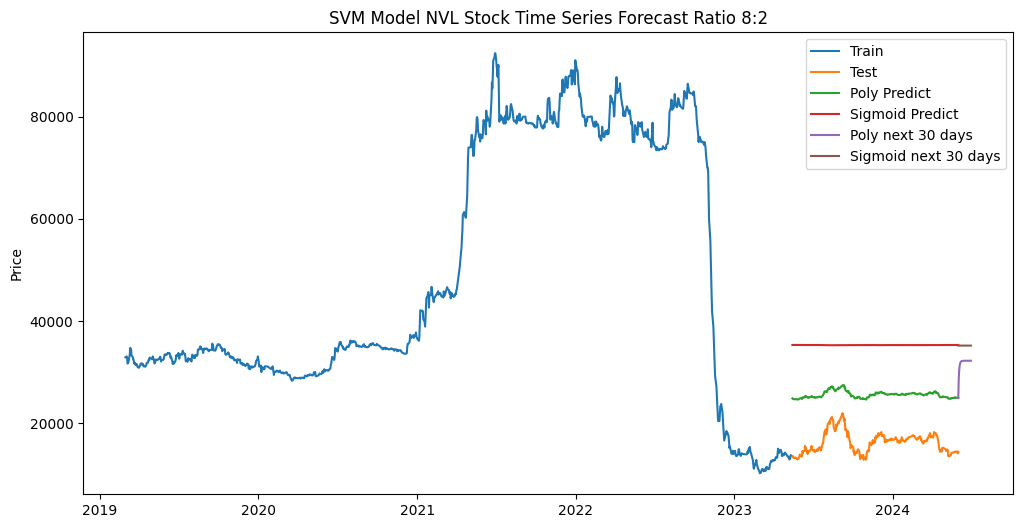

In [59]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model NVL Stock Time Series Forecast Ratio 8:2')
plt.ylabel('Price')
plt.legend()
plt.show()

In [60]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 59.33549360052973
Poly MAE: 9333.822552079115
Poly RMSE: 9441.460475280506
Sigmoid MAPE: 120.46960242527531
Sigmoid MAE: 19051.9019666981
Sigmoid RMSE: 19161.949109737023


#### Ratio 9:1

In [61]:
# Split data into train and test
train_size = int(0.9 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [62]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [63]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [64]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([24337.04045035]), array([27740.33256905]), array([29313.20887636]), array([30109.59457378]), array([30529.56901681]), array([30755.57625024]), array([30878.4966129]), array([30945.73092631]), array([30982.61984686]), array([31002.89348708]), array([31014.04588384]), array([31020.18385459]), array([31023.56296578]), array([31025.42353904]), array([31026.44807626]), array([31027.01227082]), array([31027.32297077]), array([31027.49407454]), array([31027.58830284]), array([31027.64019539]), array([31027.66877324]), array([31027.68451143]), array([31027.69317866]), array([31027.69795182]), array([31027.70058047]), array([31027.7020281]), array([31027.70282533]), array([31027.70326437]), array([31027.70350616]), array([31027.70363932])]
Sigmoid: [array([34510.48531421]), array([34493.83128707]), array([34493.90507547]), array([34493.90474842]), array([34493.90474987]), array([34493.90474986]), array([34493.90474986]), array([34493.90474986]), array([34493.90474986]), array([344

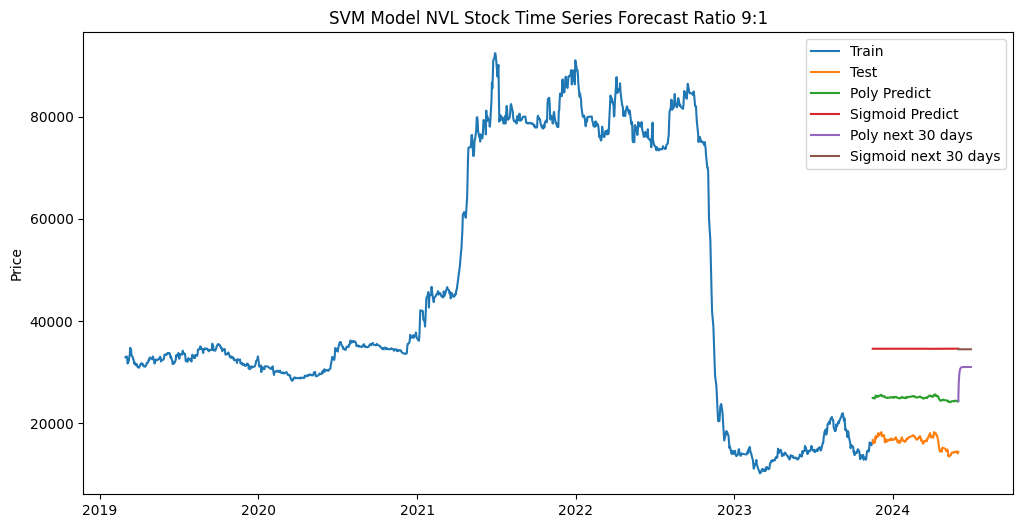

In [65]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model NVL Stock Time Series Forecast Ratio 9:1')
plt.ylabel('Price')
plt.legend()
plt.show()

In [66]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 52.41356723789472
Poly MAE: 8517.072581677834
Poly RMSE: 8560.875587254399
Sigmoid MAPE: 111.23088546801152
Sigmoid MAE: 18122.965156834798
Sigmoid RMSE: 18164.039066179


### Dataset: NLG Historical Data

In [67]:
data = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,18706.8,18496.6,18776.9,18496.6,365.80K,1.14%
2019-03-04,19127.2,18706.8,19127.2,18636.7,1.08M,2.25%
2019-03-05,18917.0,19127.2,19127.2,18846.9,468.76K,-1.10%
2019-03-06,18846.9,18987.1,19057.1,18811.9,225.18K,-0.37%
2019-03-07,18706.8,18846.9,18987.1,18671.8,453.92K,-0.74%
...,...,...,...,...,...,...
2024-05-27,43900.0,43900.0,44200.0,43000.0,1.56M,0.00%
2024-05-28,43701.0,43404.0,44047.0,43108.0,2.20M,-0.45%
2024-05-29,44400.0,43900.0,44600.0,43500.0,2.84M,1.60%


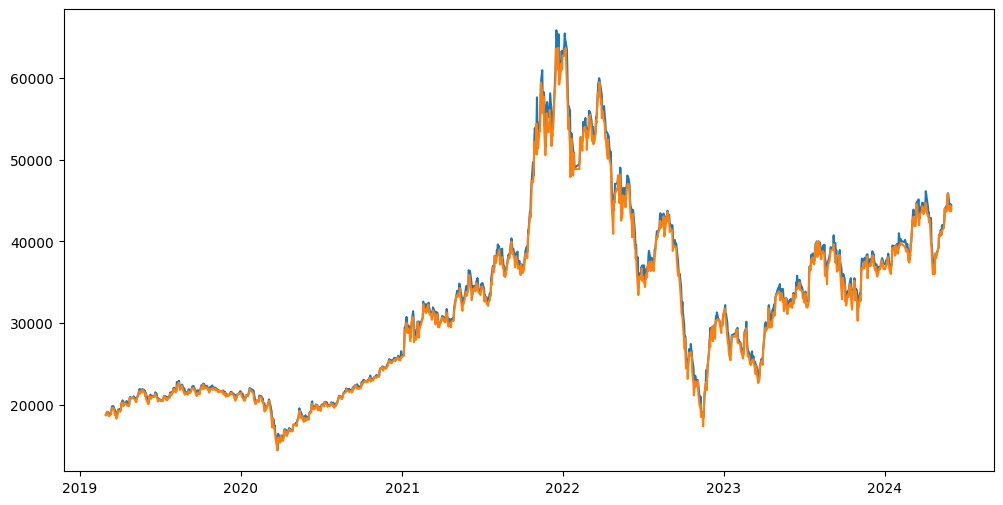

In [68]:
y = data[['Price']] # dependent variable
X = data[['High']] # independent variable
plt.figure(figsize=(12, 6))
plt.plot(X)
plt.plot(y)
plt.show()

#### Ratio 7:3

In [69]:
# Split data into train and test
train_size = int(0.7 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [70]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [71]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [72]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([41530.37391691]), array([38659.92392478]), array([35531.89887094]), array([32378.16766593]), array([29467.73710217]), array([27021.67994493]), array([25143.95444046]), array([23812.84118096]), array([22927.26402554]), array([22364.77441966]), array([22018.56826831]), array([21809.75735214]), array([21685.38997091]), array([21611.88009206]), array([21568.62824759]), array([21543.24829569]), array([21528.37914603]), array([21519.67600892]), array([21514.58471966]), array([21511.60729672]), array([21509.86640463]), array([21508.84862081]), array([21508.25362844]), array([21507.90581132]), array([21507.7024909]), array([21507.58363918]), array([21507.51416447]), array([21507.47355325]), array([21507.44981415]), array([21507.43593759])]
Sigmoid: [array([25376.47081718]), array([25374.42617573]), array([25374.42681951]), array([25374.42681931]), array([25374.42681931]), array([25374.42681931]), array([25374.42681931]), array([25374.42681931]), array([25374.42681931]), array([25

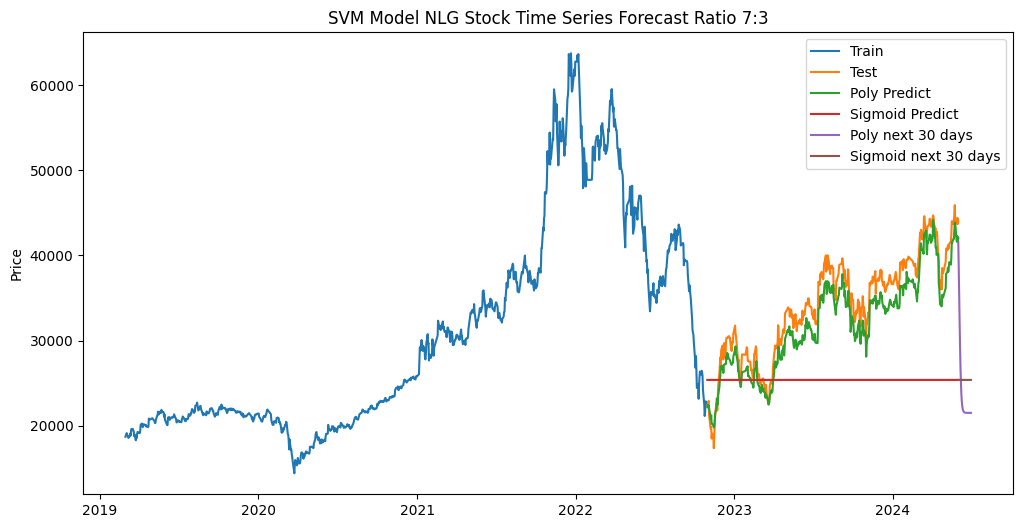

In [73]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model NLG Stock Time Series Forecast Ratio 7:3')
plt.ylabel('Price')
plt.legend()
plt.show()

In [74]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 6.148570481250389
Poly MAE: 2102.7822446714895
Poly RMSE: 2241.5030590062906
Sigmoid MAPE: 25.246225198692468
Sigmoid MAE: 9182.9907207661
Sigmoid RMSE: 10565.157579857962


#### Ratio 8:2

In [75]:
# Split data into train and test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [76]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [77]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [78]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([41961.44266892]), array([39541.38599974]), array([36817.44856648]), array([33944.97970371]), array([31137.88562715]), array([28614.85488028]), array([26532.86179832]), array([24947.21765328]), array([23819.9063874]), array([23060.68243295]), array([22569.13903158]), array([22259.39029024]), array([22067.62811298]), array([21950.23830762]), array([21878.87774244]), array([21835.68409259]), array([21809.60785416]), array([21793.89043423]), array([21784.42585086]), array([21778.72983935]), array([21775.30303664]), array([21773.24185444]), array([21772.00223338]), array([21771.2567661]), array([21770.80848707]), array([21770.5389265]), array([21770.37683616]), array([21770.27937005]), array([21770.22076332]), array([21770.18552301])]
Sigmoid: [array([26000.2088015]), array([25999.01344863]), array([25999.01362572]), array([25999.01362569]), array([25999.01362569]), array([25999.01362569]), array([25999.01362569]), array([25999.01362569]), array([25999.01362569]), array([25999

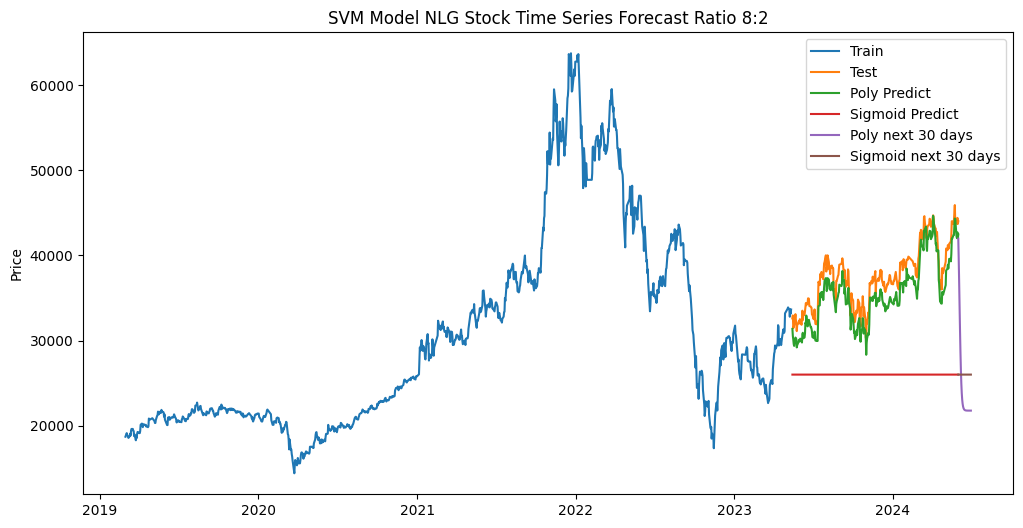

In [79]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model NLG Stock Time Series Forecast Ratio 8:2')
plt.ylabel('Price')
plt.legend()
plt.show()

In [80]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 5.577009425469229
Poly MAE: 2056.393023660272
Poly RMSE: 2148.3902511616834
Sigmoid MAPE: 29.91934974825053
Sigmoid MAE: 11449.14777502569
Sigmoid RMSE: 12014.35588841461


#### Ratio 9:1

In [81]:
# Split data into train and test
train_size = int(0.9 * len(data))
test_size = len(data) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [82]:
# Create SVR model with different kernels (poly, sigmoid)
svr_poly = SVR(kernel='poly', C=1000, degree = 2)
svr_poly.fit(X_train, y_train)

svr_sigmoid = SVR(kernel='sigmoid')
svr_sigmoid.fit(X_train, y_train)

SVR(kernel='sigmoid')

In [83]:
# Predict
y_pred_poly = svr_poly.predict(X_test)
y_pred_poly = y_pred_poly.reshape(-1,1)

y_pred_sigmoid = svr_sigmoid.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [84]:
last_index = data.index[-1]
last_row = data.tail(1)
last_data = last_row['Price'].values.reshape(-1,1)
last_data

# Predict the next 30 days
x_next_30_day_rbf = []
x_next_30_day_poly = []
x_next_30_day_sigmoid = []
index_next_30_days = np.array(pd.date_range(start=data.index[-1], periods=30)).reshape(-1, 1)

for i in range(30):
    x_pred_next = svr_poly.predict(last_data)
    x_next_30_day_poly.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

for i in range(30):
    x_pred_next = svr_sigmoid.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print("Poly:", x_next_30_day_poly)
print("Sigmoid:", x_next_30_day_sigmoid)

Poly: [array([43019.39300062]), array([41787.09826608]), array([40277.89671623]), array([38489.3151758]), array([36454.81481283]), array([34252.90793307]), array([32004.52979862]), array([29853.19726663]), array([27931.41112635]), array([26327.71977984]), array([25071.11943857]), array([24138.39353349]), array([23475.55666018]), array([23019.78803247]), array([22713.76264688]), array([22511.64886486]), array([22379.64640922]), array([22294.07125287]), array([22238.86308298]), array([22203.3581892]), array([22180.57116941]), array([22165.96565586]), array([22156.61202782]), array([22150.62503607]), array([22146.79425896]), array([22144.34367907]), array([22142.77624509]), array([22141.77377772]), array([22141.13267733]), array([22140.72269445])]
Sigmoid: [array([29216.77769848]), array([29216.00151882]), array([29216.00154297]), array([29216.00154296]), array([29216.00154296]), array([29216.00154296]), array([29216.00154296]), array([29216.00154296]), array([29216.00154296]), array([292

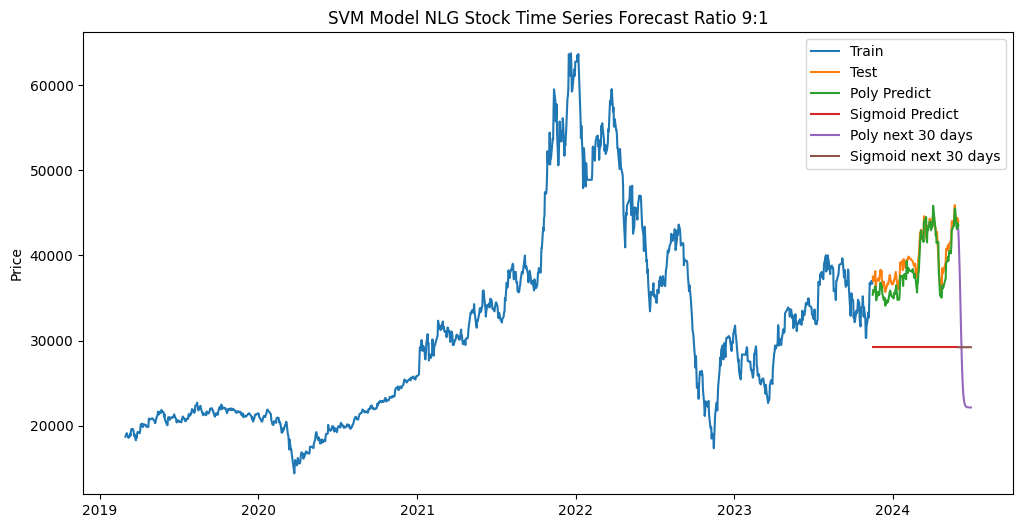

In [85]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_poly, label='Poly Predict')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')

# Predict the next 30 days by using Poly and Sigmoid
plt.plot(index_next_30_days,x_next_30_day_poly, label='Poly next 30 days')
plt.plot(index_next_30_days,x_next_30_day_sigmoid, label='Sigmoid next 30 days')

plt.title('SVM Model NLG Stock Time Series Forecast Ratio 9:1')
plt.ylabel('Price')
plt.legend()
plt.show()

In [86]:
# Calculate errors
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(np.mean((y_pred_poly - y_test)**2))

mape_sigmoid = mean_absolute_percentage_error(y_test, y_pred_sigmoid) * 100
mae_sigmoid = mean_absolute_error(y_test, y_pred_sigmoid)
rmse_sigmoid = np.sqrt(np.mean((y_pred_sigmoid - y_test)**2))

print("Poly MAPE:", mape_poly)
print("Poly MAE:", mae_poly)
print("Poly RMSE:", rmse_poly)

print("Sigmoid MAPE:", mape_sigmoid)
print("Sigmoid MAE:", mae_sigmoid)
print("Sigmoid RMSE:", rmse_sigmoid)

Poly MAPE: 3.155703595023579
Poly MAE: 1224.4382636245891
Poly RMSE: 1361.1491123298804
Sigmoid MAPE: 26.319076935397717
Sigmoid MAE: 10637.893388336175
Sigmoid RMSE: 11018.149191848863
